# Lancet Countdown South America - Indicator 5.3

This notebook contains the analysis which measures scientific engagement on climate and health in South America. It builds on data generated in [Berrang-Ford et al. 2021](https://www.thelancet.com/journals/lanplh/article/PIIS2542-5196(21)00179-0/fulltext), which was updated for the Lancet Countdown.

## Importing data and packages
First we need to import the packages required for our analysis, as well as the data, which is distributed across multiple files
- `data/included_docs.csv` contains a row for each document. The columns contain metadata about the document, including its predicted relevance to climate and health, and its predicted relevance to Mitigation, Adaptation, and Impacts
- `data/clean_place_df.csv` contains a row for each geographical location found in the documents, information about that location, and the ID of the document in which it was found. There may be 0, 1 or multiple rows for each document
- `data/institutional_locations.csv` contains a row for each country-document pair found in the affiliations provided for each document.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
import cartopy.crs as ccrs
import geopandas
import cartopy.io.shapereader as shpreader

In [2]:
df = pd.read_csv('data/included_docs.csv')
df.head()

,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,1 - Adaptation,1 - Impacts,1 - Mitigation,wosarticle__dt,tslug,UT__UT,0 - relevance - prediction,1 - Mitigation - prediction,1 - Adaptation - prediction,1 - Impacts - prediction
0,4963912,Objective To explore the association between n...,Exploration of the association between meteoro...,2021.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,Article,explorationoftheassociationbetweenmeteorologic...,2-s2.0-85123003389,0.790797,0.010609,0.006835,0.980508
1,4729030,Background. Acute gastroenteritis is a cause o...,ACUTE GASTROENTERITIS IN 3 COMMUNITY-BASED NUR...,1995.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,Article,acutegastroenteritisin3communitybasednursinghomes,WOS:A1995RY60500014,0.714243,0.024695,0.073035,0.910536
2,4762134,Background: Despite declining age-adjusted str...,Mortality and Predictors of Death 1 Month and ...,2010.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,Article,mortalityandpredictorsofdeath1monthand3yearsaf...,WOS:000273552100004,0.554120,0.029360,0.061142,0.938161
3,678134,Weather factors are widely studied for their e...,Statistical Modeling Reveals the Effect of Abs...,2014.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,Article,statisticalmodelingrevealstheeffectofabsoluteh...,WOS:000337735100017,0.957414,0.004876,0.007306,0.992824
4,304387,The aim of this study was to determine the hea...,A systematic review of the health effects of p...,2015.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,Review,asystematicreviewofthehealtheffectsofprenatale...,WOS:000364521200008,0.588936,0.003917,0.044029,0.944127


In [3]:
places = pd.read_csv('data/clean_place_df.csv')
places.head()

,word,spans,country_predicted,country_conf,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,continent
0,Shanghai,"[{'start': 162, 'end': 170}]",CHN,0.963741,Shanghai,31.22222,121.45806,CHN,1796236.0,Shanghai,P,PPLA,4963912,Asia
1,Thailand,"[{'start': 57, 'end': 65}]",THA,0.948191,NaN,15.50000,101.00000,THA,1605651.0,Kingdom of Thailand,A,PCLI,4695222,Asia
2,Bangkok,"[{'start': 302, 'end': 309}]",THA,0.961249,Bangkok,13.75398,100.50144,THA,1609350.0,Bangkok,P,PPLC,4695222,Asia
3,Israel,"[{'start': 285, 'end': 291}]",ISR,0.948191,NaN,31.50000,34.75000,ISR,294640.0,State of Israel,A,PCLI,4762134,Asia
4,Singapore,"[{'start': 74, 'end': 83}]",SGP,0.946707,NaN,1.36667,103.80000,SGP,1880251.0,Republic of Singapore,A,PCLI,678134,Asia


In [4]:
institutions = pd.read_csv('data/institutional_locations.csv')
institutions.head()

,id,doc_id,surname,initials,AU,AF,institution,position,country,alpha_3,name,alpha_2
0,1217824,562,NaN,NaN,"Pinkerton, KE","Pinkerton, Kent E.","Univ Calif Davis, Ctr Hlth & Environm, Davis, ...",4,USA,USA,United States,US
1,1217742,562,NaN,NaN,"Thurston, GD","Thurston, George D.","NYU, Dept Environm Med, Sch Med, New York, NY ...",2,USA,USA,United States,US
2,1217830,562,NaN,NaN,"Pinkerton, KE","Pinkerton, Kent E.","Univ Calif Davis, John Muir Inst Environm, Dav...",4,USA,USA,United States,US
3,1217730,562,NaN,NaN,"Rice, MB","Rice, Mary B.","Harvard Univ, Beth Israel Deaconess Med Ctr, S...",1,USA,USA,United States,US
4,1217695,562,NaN,NaN,"Rice, MB","Rice, Mary B.","Massachusetts Gen Hosp, Pulm & Crit Care Unit,...",1,USA,USA,United States,US


## Plotting frequencies of documents

Now we have loaded our documents, we want to plot the frequency of documents per year. In particular, we would like to focus on a subset which either mentions, or is authored by someone with an affiliation from, one of the countries below

In [5]:
countries = [
    "ARG",
    "BOL",
    "BRA",
    "CHL",
    "COL",
    "ECU",
    "GUY",
    "PRY",
    "PER",
    "SUR",
    "URY",
    "VEN"
]
# Get the document IDs where the document mentions a place in one of our countries
country_doc_ids = places.loc[places["country_code3"].isin(countries), "doc_id"]
# Get the document IDs where one of the authors has an affiliation in one of our countries
author_country_doc_ids = institutions.loc[institutions.alpha_3.isin(countries), "doc_id"]


,n,n-5,CAGR_5,CAGR_1995,CAGR_2000,CAGR_2005
PY,,,,,,
1991.0,1,NaN,NaN,NaN,NaN,NaN
1993.0,1,NaN,NaN,NaN,NaN,NaN
1994.0,2,NaN,NaN,NaN,NaN,NaN
1995.0,3,NaN,NaN,NaN,NaN,NaN
1996.0,2,NaN,NaN,NaN,NaN,NaN


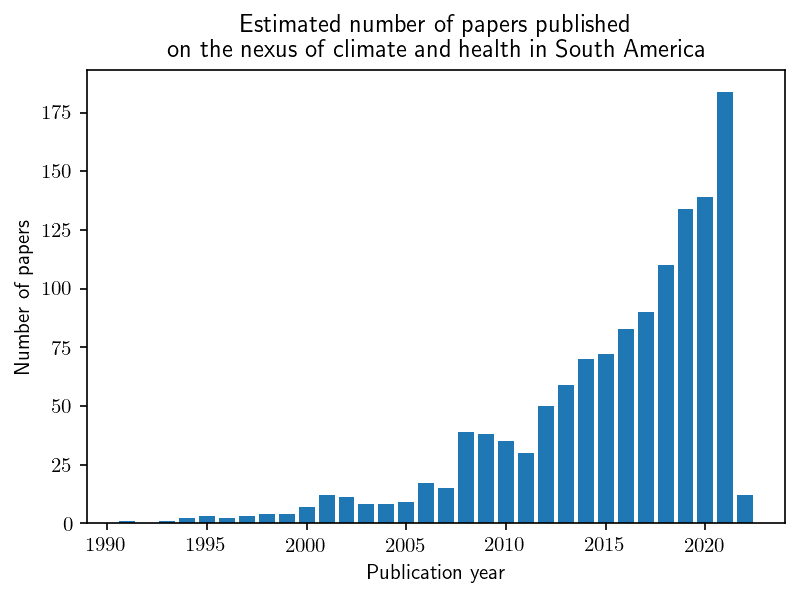

In [6]:
# We'll make a function to plot the counts of documents from a certain subset of IDs, returning a table
def plot_counts(df, ids, title):
    counts = df[df['id'].isin(ids)].groupby('PY')['id'].count()

    fig, ax = plt.subplots(dpi=150)
    ax.bar(counts.index, counts)

    ax.set_ylabel('Number of papers')
    ax.set_xlabel('Publication year')
    ax.set_title(title)

    def CAGR(first, last, periods):
        if periods > 0:
            return (last/first)**(1/periods)-1

    counts = counts.to_frame("n")
    counts['n-5'] = counts.shift(5)
    counts['CAGR_5'] = counts.apply(lambda x: CAGR(x['n-5'],x['n'],5),axis=1)

    for base_year in [1995, 2000, 2005]:
        counts[f'CAGR_{base_year}'] = counts.apply(lambda x: CAGR(counts[counts.index==base_year]['n'].values[0],x['n'],x.name-2000), axis=1)

    totals = counts.copy()
    return totals
    
total_mentions = plot_counts(df, country_doc_ids, 'Estimated number of papers published \non the nexus of climate and health in South America')
total_mentions.head()

In [7]:
total_mentions.copy()

,n,n-5,CAGR_5,CAGR_1995,CAGR_2000,CAGR_2005
PY,,,,,,
1991.0,1,NaN,NaN,NaN,NaN,NaN
1993.0,1,NaN,NaN,NaN,NaN,NaN
1994.0,2,NaN,NaN,NaN,NaN,NaN
1995.0,3,NaN,NaN,NaN,NaN,NaN
1996.0,2,NaN,NaN,NaN,NaN,NaN
1997.0,3,1.0,0.245731,NaN,NaN,NaN
1998.0,4,1.0,0.319508,NaN,NaN,NaN
1999.0,4,2.0,0.148698,NaN,NaN,NaN
2000.0,7,3.0,0.184664,NaN,NaN,NaN


,1 - Impacts,1 - Adaptation,1 - Mitigation,Total unique papers
PY,,,,
2018.0,93,7.0,9.0,110
2019.0,127,10.0,4.0,134
2020.0,129,1.0,14.0,139
2021.0,172,9.0,12.0,184
2022.0,9,0.0,3.0,12


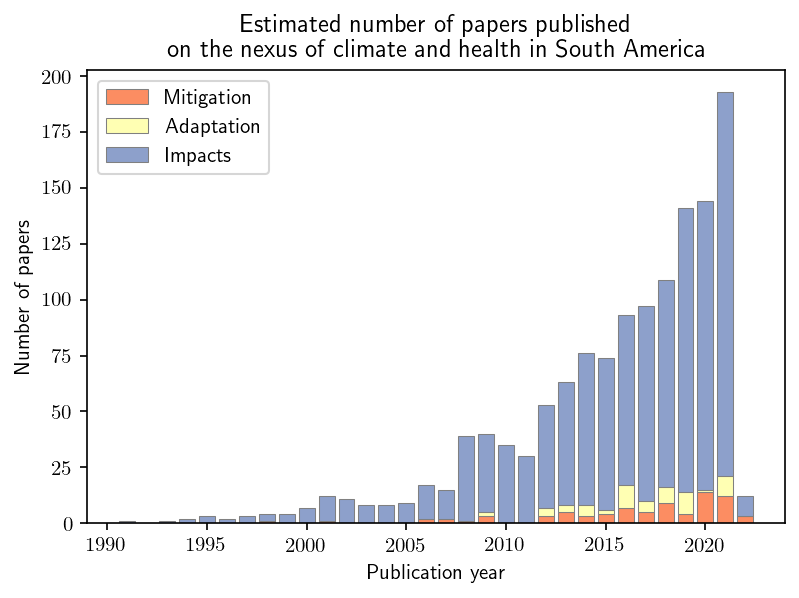

In [8]:
fig, ax = plt.subplots(dpi=150)

colors = ['#fc8d62','#ffffb3','#8da0cb']
class_counts = total_mentions.copy()['n'].rename("Total unique papers")
bottom = np.zeros(class_counts.shape[0])

classes = ["1 - Mitigation", "1 - Adaptation", "1 - Impacts"]
for i, c in enumerate(classes):
    counts = df[
        (df['id'].isin(country_doc_ids)) & 
        (df[f'{c} - prediction']>0.5)
    ].groupby('PY')['id'].count().to_frame(c)
    
    class_counts = counts.merge(class_counts, left_index=True, right_index=True, how="outer").fillna(0)
    
    ax.bar(
        class_counts.index, class_counts[c], 
        bottom=bottom, label=c.split(' - ')[1],
        color=colors[i], ec="grey",lw=0.5
    )
    bottom += class_counts[c]
    
    ax.set_ylabel('Number of papers')
    ax.set_xlabel('Publication year')

    ax.set_title('Estimated number of papers published \non the nexus of climate and health in South America')
    
ax.legend()
class_counts.to_csv('output_data/scientific_papers_south_america.csv')
class_counts.tail()

# Mapping studies

In [9]:
# Read in a shapefile with country boundaries
shpfilename = shpreader.natural_earth(
    resolution='10m',
    category='cultural',
    name='admin_0_countries'
)
adm0shps = geopandas.read_file(shpfilename,encoding='utf-8')

# This gives us a count of documents located in each place
all_place_counts = (df[(df['PY']==2021) & (df['id'].isin(country_doc_ids))]
                    .merge(places, left_on="id", right_on="doc_id")
                    .groupby(['lat', 'lon','country_code3','feature_code'])['doc_id']
                    .count()
                    .sort_values()
                    .reset_index()
                   )

# We merge the places which are countries with our shapefile data
country_counts = adm0shps.merge(all_place_counts[all_place_counts['feature_code']=="PCLI"],left_on="ADM0_A3",right_on="country_code3")
# The rest we will plot as points
place_counts = all_place_counts[all_place_counts['feature_code']!="PCLI"]

Text(0.0, 1.0, 'a. Number of publications on the nexus of climate and health in South America')

/home/max/software/py39/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/max/software/py39/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/max/software/py39/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/max/software/py39/lib/python3.9/site-packages/cartopy/crs.py:228

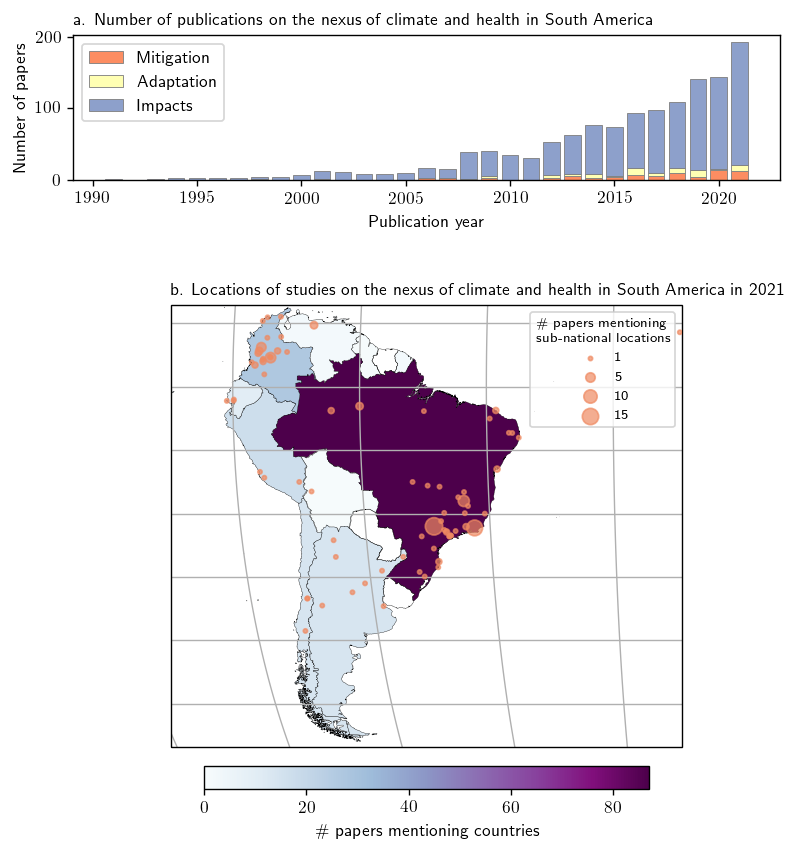

In [10]:
# Set up a figure with gridspec to have different sizes for the plot elements
fig = plt.figure(dpi=125,figsize=(7.3,6.7))
gs = gridspec.GridSpec(2, 1, height_ratios=[.3, 1,], bottom=.05, top=.95, wspace=.2, hspace=.4)

#############################################################################
## First we want to do our map
p = ccrs.EckertIII()
ax = plt.subplot(gs[1,0],projection=p)
ax.set_extent([-90,-10,-50,10])
ax.gridlines()

# Set the fontsize
tfs = 10

# Set a colour map and normalisation for our country data
cmap = mpl.cm.get_cmap('BuPu')
norm = mpl.colors.Normalize(vmin=0, vmax=country_counts['doc_id'].max())

# Add a shape for each country
for i, row in country_counts.iterrows():
    ax.add_geometries(
        [row['geometry']],fc=cmap(norm(row['doc_id'])), 
        crs=ccrs.PlateCarree(),lw=0.2, ec="black"
    )
    
# Also add a transparent shape for each missing country
missing_countries = adm0shps[
    (adm0shps['ADM0_A3'].isin(countries)) & 
    (~adm0shps['ADM0_A3'].isin(country_counts['ADM0_A3']))
]
for i, row in missing_countries.iterrows():
    ax.add_geometries(
        [row['geometry']],fc="None", 
        crs=ccrs.PlateCarree(), ec="black", lw=0.2
    )

# Show the colorbar
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
    ax=ax, orientation="horizontal",
    fraction=0.046, pad=0.04
)
cbar.set_label('\# papers mentioning countries')

# Use separate normalisation for the non-country places
norm = mpl.colors.Normalize(vmin=0, vmax=place_counts['doc_id'].max())

# Plot these as points
ax.scatter(
    place_counts['lon'], place_counts['lat'], 
    transform=ccrs.PlateCarree(), 
    s=norm(place_counts['doc_id'])*100,
    alpha=0.7,
    color="#ef8a62",
    zorder=10
)

# Create legend labels
bins = np.array([1,5,10,15])
for bin_i in bins: 
    ax.scatter(
        [],[], 
        transform=ccrs.PlateCarree(), 
        s=norm(bin_i)*100,
        label=bin_i,
        alpha=0.7,
        color="#ef8a62",
    )
    
leg = ax.legend(title="\# papers mentioning\nsub-national locations",fontsize=8)
leg.get_title().set_fontsize('8')
ax.set_title('b. Locations of studies on the nexus of climate and health in South America in 2021', loc="left", fontsize=tfs)

###############################################
## The second part of the plot plots the number of documents

ax = plt.subplot(gs[0,0])
class_counts = class_counts[class_counts.index<2022]

bottom = 0
for i, c in enumerate(classes):
    ax.bar(
        class_counts.index, class_counts[c], 
        bottom=bottom, label=c.split(' - ')[1],
        color=colors[i], ec="grey",lw=0.5
    )
    bottom += class_counts[c]   

ax.set_ylabel('Number of papers')
ax.set_xlabel('Publication year')  
ax.legend()

ax.set_ylabel('Number of papers')
ax.set_xlabel('Publication year')

ax.set_title('a. Number of publications on the nexus of climate and health in South America', loc="left", fontsize=tfs)


## Topic modelling

Now we want to explore which topics are more or less common in our subset of the dataset. The results of our topic model are contained in `data/doc_topic_scores.csv`, where each row has the id of a document, the id of a topic, and the score for that topic in that document. `data/topic_info.csv` contains more information about the topics, and has a title we can use

In [11]:
# Import topics
dtm = pd.read_csv('data/doc_topic_scores.csv')
dtm.head()

,doc_id,topic_id,score
0,4963912,213122,0.000206
1,4729030,213122,0.000412
2,678134,213122,0.010642
3,3388074,213122,0.002163
4,670073,213122,0.019230


In [12]:
# Load topic info
topic_info = pd.read_csv('data/topic_info.csv')
exclude_topics = topic_info[topic_info['Aggregated meta-topic']=="Other"]["id"]
topic_info.head()

,id,title,top_words,Topic ID,Aggregated meta-topic,Aggregated topic,Topic,color,short_title
0,213142,"Viral, Viral diseases","['transmiss', 'outbreak', 'virus', 'wnv', 'epi...",213142,Health impact,Infectious,Transmission,#fed9a6,Viral
1,213146,"Seasonality, Seasonality","['season', 'winter', 'summer', 'variat', 'dure...",213146,Exposure,General seasonality & weather,Seasonality,#fbb4ae,Seasonality
2,213181,"Building design, Building design","['indoor', 'outdoor', 'home', 'build', 'hous',...",213181,Mediating pathways,Geographic exposure,Building design,#b3cde3,Building design
3,213155,"Stroke, Stroke","['stroke', 'ischem', 'hemorrhag', 'associ', 's...",213155,Health impact,Chronic,Stroke,#fed9a6,Stroke
4,213148,"HFMD, Hand-foot-and-mouth disease","['hfmd', 'foot', 'mouth', 'hand', 'factor', 'd...",213148,Health impact,Infectious,HFMD,#fed9a6,HFMD


In [13]:
# Get the sum of all doctopic scores for each topic
dt_sum = pd.DataFrame(
    dtm.groupby('topic_id')['score']
    .sum()
).reset_index().rename(columns={"score":"total_score"})

# Calculate these as the share of total scores
dt_sum['total_share'] = dt_sum['total_score'] / dt_sum['total_score'].sum()
dt_sum.head()

,topic_id,total_score,total_share
0,213122,196.225812,0.030621
1,213123,197.412146,0.030807
2,213124,109.560517,0.017097
3,213125,19.805708,0.003091
4,213126,91.184594,0.014230


In [14]:

# This function will calculate topic shares for a subgroup and return a list of more common and less common topics compared to the whole dataset
def get_group_topics(name, ids, dts, dt_sum, topic_info, nlabs=5, exclude_topics=None, include_topics=None):
    if exclude_topics is not None:
        dts = dts[~dts['topic_id'].isin(exclude_topics)]
    gdt = dts[dts['doc_id'].isin(ids)]
    gdt = pd.DataFrame(gdt.groupby('topic_id')['score'].aggregate("sum")).reset_index()
    gdt['continent'] = name
    gdt['share'] = gdt['score'] / gdt['score'].sum()    
    
    gdt = gdt.merge(dt_sum)
    gdt['deviation'] = gdt['share'] / gdt['total_share']
    
    if include_topics is not None:
        gdt = gdt[gdt['topic_id'].isin(include_topics)]
    
    top_topics = gdt.sort_values('deviation').tail(nlabs).merge(topic_info,left_on="topic_id",right_on="id")
    bottom_topics = gdt.sort_values('deviation').head(nlabs).merge(topic_info,left_on="topic_id",right_on="id")    
    
    return {
        "name": name,
        "common_topics": [x.split(',')[0] for x in top_topics.title],
        "common_topics_scores": top_topics.deviation,
        "uncommon_topics": [x.split(',')[0] for x in bottom_topics.title],
        "uncommon_topics_scores": bottom_topics.deviation
    }



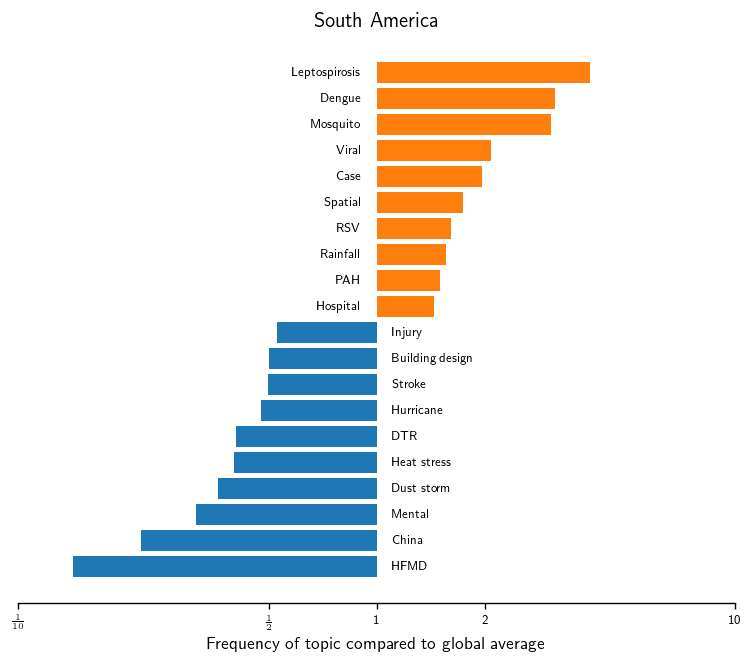

In [15]:
# We can feed this function our list of documents mentioning south america to see which topics are over- or under-represented here
cr = get_group_topics("South America", country_doc_ids, dtm, dt_sum, topic_info, nlabs=10)

fig, ax = plt.subplots(figsize=(7.4,6), dpi=125)

# And define a function to 
def plot_topic_rep(cr, ax, xlabel=None, fs=7):
    
    # Do a horizontal bar plot - we use the log so that half as frequent and twice as frequent are symmetrical
    l = len(cr["common_topics_scores"])
    pad=0.1
    ax.barh(range(l),np.log(cr["uncommon_topics_scores"]))
    ax.barh(range(l,l*2),np.log(cr["common_topics_scores"]))
    # Label each bar
    for j, lab in enumerate(cr["uncommon_topics"]):
        ax.text(0+pad,j,lab,ha="left", va="center", fontsize=fs, usetex=True)
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0-pad,j+l, lab, ha="right", va="center", fontsize=fs, usetex=True)
    
    # remove axes and y ticks
    sns.despine(ax=ax,top=True,left=True)
    ax.set_yticks([])    
    
    # Set the title
    ax.set_title(cr["name"])
    
    # Align x labels
    xlab_positions = [.1,.5,1,2,10]
    xlabels = [r"$\frac{1}{10}$",r"$\frac{1}{2}$",1,2,10]
    ax.set_xticks([np.log(lab) for lab in xlab_positions])
    ax.set_xticklabels(xlabels, fontsize=fs, usetex=True)
    if xlabel:
        ax.set_xlabel(xlabel)
        
plot_topic_rep(cr, ax, "Frequency of topic compared to global average")

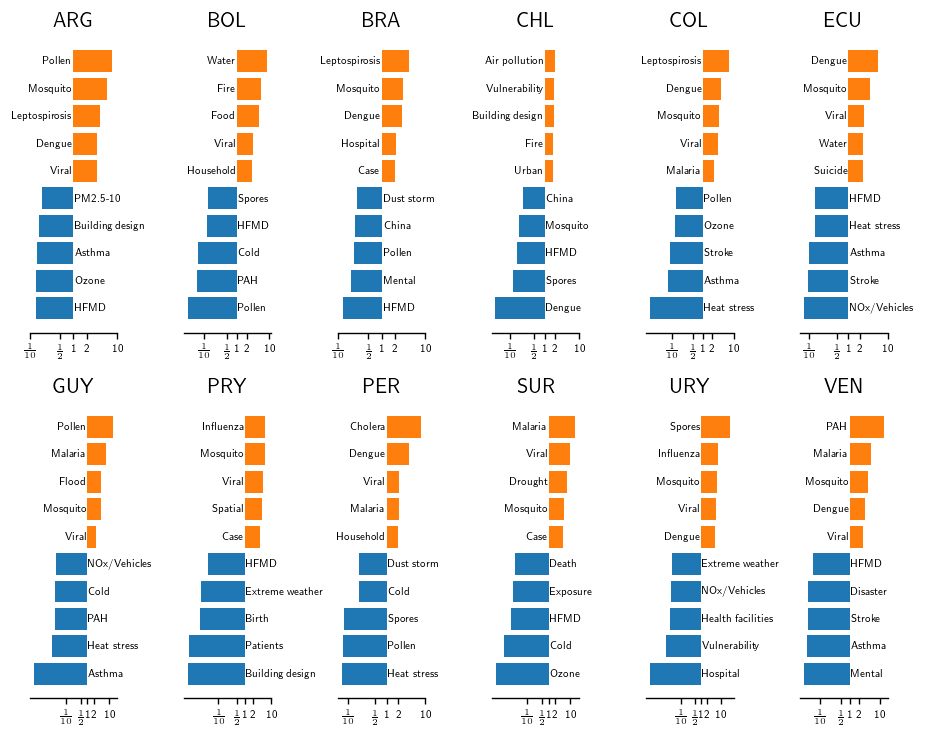

In [16]:
# Now we can do this for each country

cols = int(len(countries)/2)
fig, axs = plt.subplots(2, cols, figsize=(7.4,6), dpi=125)

for i, name in enumerate(countries):
    ids = places.loc[places.country_code3==name,"doc_id"]
    cr = get_group_topics(name, ids, dtm, dt_sum, topic_info)
    ax = axs[i//cols,i%cols]
    
    plot_topic_rep(cr, ax, fs=6)


continent_df = pd.DataFrame

fig.tight_layout()

# Affiliations

Author affiliations are contained in the institutions dataframe. We can use this to plot the institutions or countries affiliated with the most documents in our dataset

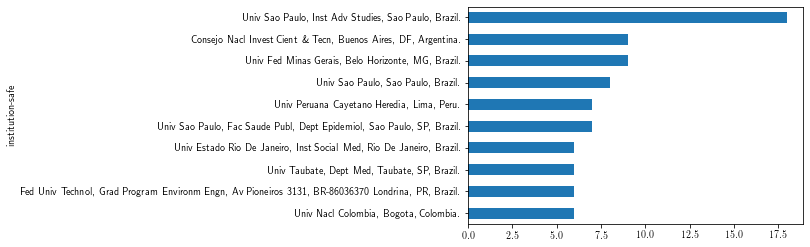

In [20]:
fig, ax = plt.subplots()
institutions["institution-safe"] = institutions["institution"].str.replace("&", "\&") # Clean text for latex
institutions[institutions.alpha_3.isin(countries)].groupby('institution-safe')["doc_id"].nunique().sort_values(ascending=False).head(10).plot.barh(ax=ax)
plt.gca().invert_yaxis()

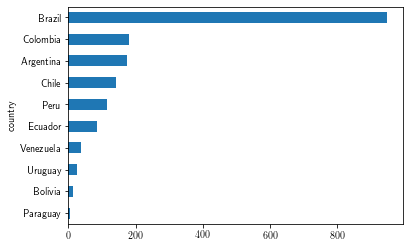

In [22]:
fig, ax = plt.subplots()
institutions[institutions.alpha_3.isin(countries)].groupby('country')["doc_id"].nunique().sort_values(ascending=False).head(10).plot.barh(ax=ax)
plt.gca().invert_yaxis()